# 问题分析
1. 预处理阶段：AI自动打标签
   - 好处：快速打标签，提高效率
   - 缺点：标签质量参差不齐，需要后续清洗
1. 再打标签阶段
1. 可视化阶段
   - 好处：直观展示数据分布，发现异常
   - 缺点：需要专业知识，耗时

# 一、准备数据

In [1]:
import pymongo
import pandas as pd
# MongoDB连接配置
mongo_client = pymongo.MongoClient("mongodb://localhost:27017/")
kinyo_db = mongo_client["kinyo_db"]
kinyo_reviews_collection = kinyo_db["kinyo_new_reviews"]
kinyo_llm_results_collection = kinyo_db["kinyo_llm_results"]

# 二、准备单条数据测试

## 1. 构建prompt模板

In [2]:
def prepare_system_prompt():
    system_prompt = f"""# 任务目标：
精确分析消费者评论并提取结构化信息，具体包括：

1. **产品话题细粒度分类**：
   - 识别评论中涉及的具体产品特性/功能点
   - 将每个话题精确匹配到预定义的细分类别（不创建新类别）
   - 提取每个话题的相关文本片段（不超过原文20%长度）
   - 为每个匹配提供置信度评分（0.0-1.0）
   - 避免过于宽泛的分类，专注于特定产品属性而非一般性描述

2. **精确情感分析**：
   - 对每个识别的话题进行独立情感判定
   - 根据文本强度和明确性区分"好评"(明显正面)/"差评"(明显负面)/"中评"(中性或模糊)
   - 考虑上下文和语气，而非仅依靠情感词汇

3. **关键词提取**：
   - 识别评论中最具信息量和区分度的产品特性词/短语
   - 每条评论提取3-5个关键词/短语，保持简洁性
   - 优先考虑产品特定词汇而非一般性描述

4. **用户画像分析**：
   - 仅基于评论中明确提及的信息进行用户特征推断
   - 不进行过度推测，无明确信息时保留字段为空

# 输出要求：
- 以json格式输出，包含以下字段：
 1. comment: 原始的评论文本（数据类型：字符串）。
 2. product_topic_result: 由匹配的评论片段、话题分类和情感倾向组成的列表，每个元素包含以下四个字段：
  - topic：分类话题（数据类型：字符串，来源于预定义的分类列表，不可改变）。
  - polarity：情感分析的结果，表示该话题的情感倾向（数据类型：字符串，值为“好评”、“差评”或“中评”）。
  - confidence：匹配置信度（数据类型：float）。
  - related_text：与话题相关的评论片段（数据类型：字符串）。
 3. keyphrases: 从评论中提取的关键词和短语（数据类型：列表）。
 4. user_profile: 从评论中提取的用户画像特征（数据类型：字典），包含年龄、性别、职业、消费场景、消费需求,没有判断出来的时候就是空:
  - gender: 用户性别（男|女,数据类型：字符串）。
  - occupation: 用户职业（数据类型：字符串）。
  - consumption_scene: 用户消费场景（数据类型：字符串）。
  - consumption_motivation: 用户消费动机（数据类型：字符串）。
  - consumption_frequency: 用户消费频率（数据类型：字符串）,首次|复购|高频。
  - consumption_satisfaction: 用户最满意的特点（数据类型：字符串）。
  - consumption_unsatisfaction: 用户最不满意的特点（数据类型：字符串）。
"""
    return system_prompt

In [3]:
print(prepare_system_prompt())

# 任务目标：
精确分析消费者评论并提取结构化信息，具体包括：

1. **产品话题细粒度分类**：
   - 识别评论中涉及的具体产品特性/功能点
   - 将每个话题精确匹配到预定义的细分类别（不创建新类别）
   - 提取每个话题的相关文本片段（不超过原文20%长度）
   - 为每个匹配提供置信度评分（0.0-1.0）
   - 避免过于宽泛的分类，专注于特定产品属性而非一般性描述

2. **精确情感分析**：
   - 对每个识别的话题进行独立情感判定
   - 根据文本强度和明确性区分"好评"(明显正面)/"差评"(明显负面)/"中评"(中性或模糊)
   - 考虑上下文和语气，而非仅依靠情感词汇

3. **关键词提取**：
   - 识别评论中最具信息量和区分度的产品特性词/短语
   - 每条评论提取3-5个关键词/短语，保持简洁性
   - 优先考虑产品特定词汇而非一般性描述

4. **用户画像分析**：
   - 仅基于评论中明确提及的信息进行用户特征推断
   - 不进行过度推测，无明确信息时保留字段为空

# 输出要求：
- 以json格式输出，包含以下字段：
 1. comment: 原始的评论文本（数据类型：字符串）。
 2. product_topic_result: 由匹配的评论片段、话题分类和情感倾向组成的列表，每个元素包含以下四个字段：
  - topic：分类话题（数据类型：字符串，来源于预定义的分类列表，不可改变）。
  - polarity：情感分析的结果，表示该话题的情感倾向（数据类型：字符串，值为“好评”、“差评”或“中评”）。
  - confidence：匹配置信度（数据类型：float）。
  - related_text：与话题相关的评论片段（数据类型：字符串）。
 3. keyphrases: 从评论中提取的关键词和短语（数据类型：列表）。
 4. user_profile: 从评论中提取的用户画像特征（数据类型：字典），包含年龄、性别、职业、消费场景、消费需求,没有判断出来的时候就是空:
  - gender: 用户性别（男|女,数据类型：字符串）。
  - occupation: 用户职业（数据类型：字符串）。
  - consumption_scene: 用户消费场景（数据类型：字符串）。
  - 

In [4]:
def prepare_user_prompt(review_str,product_name):
    user_prompt = f"""# 客户评论：
- {review_str}
# 产品名称：
- {product_name}
"""
    return user_prompt

In [5]:
# imports
import ast  # for converting embeddings saved as strings back to arrays
from openai import OpenAI # for calling the OpenAI API
import pandas as pd  # for storing text and embeddings data
import tiktoken  # for counting tokens
import os # for getting API token from env variable OPENAI_API_KEY
from scipy import spatial  # for calculating vector similarities for search
import json
# create a list of models 
GPT_MODELS = ["gpt-4o", "gpt-4o-mini"]
# models
EMBEDDING_MODEL = "text-embedding-3-small"

In [6]:
# Set the proxy URL and port
proxy_url = 'http://127.0.0.1'
proxy_port = 6465 # !!!please replace it with your own port

# Set the http_proxy and https_proxy environment variables
os.environ['http_proxy'] = f'{proxy_url}:{proxy_port}'
os.environ['https_proxy'] = f'{proxy_url}:{proxy_port}'

client = OpenAI(api_key=os.getenv('OPEN_AI_KEY'))

## 2. 调用模型获取结果

In [7]:
from typing import Dict, Any  # 添加类型注解导入
# 调用模型获取结果
def get_first_label_response(review: Dict[str, Any],model:str="gpt-4o-mini"):
    review_str = review['评论']
    product_name = review['商品名称']
    try:
        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": prepare_system_prompt()},
                {"role": "user", "content": prepare_user_prompt(review_str=review_str,product_name=product_name)}
            ],
            stream=False,
            response_format={'type': 'json_object'}
        )

        # 获取 token 消耗数量
        token_usage = response.usage.total_tokens if hasattr(response, 'usage') else None
        # 解析内容
        content = response.choices[0].message.content
        parsed_content = json.loads(content)  # 解析内容
        parsed_content['token_usage'] = token_usage
        parsed_content["review_id"] = review["review_id"]
        return parsed_content
    except Exception as e:
        print(f"Error: {e}")
        return None

In [8]:
# 随机获取一个评论
random_review = kinyo_reviews_collection.aggregate([{ "$sample": { "size": 1 } }])
random_review_doc = next(random_review, None)  # 获取第一个结果，如果没有则返回None

# 如果需要打印出来看结果
if random_review_doc:
    print(random_review_doc)

{'_id': ObjectId('6805e4d8c865ccb2f135a697'), '评论': '暂时没发现问题，当时感觉声音一般', '商品规格': '热销无线领夹版丨粉色', '评论时间': '2025-04-06', '评论来源': '四川', '客户ID': ' s***n', '商品SKU': 100133339041, '来源平台': '京东', '来源品牌': '索爱', '数据类型': '竞品', '商品名称': ' 索爱（soaiy）655无线磁吸领夹小蜜蜂扩音器教师专用蓝牙音箱音响防啸叫TF卡喇叭磁吸麦克风导游户外便携式 粉', '来源店铺': '索爱影音京东自营官方旗舰店', 'review_id': '530ac911-9f28-4086-a8a2-f5effc03f2eb'}


In [9]:
get_first_label_response(random_review_doc)

{'comment': '暂时没发现问题，当时感觉声音一般',
 'product_topic_result': [{'topic': '音质',
   'polarity': '中评',
   'confidence': 0.7,
   'related_text': '声音一般'}],
 'keyphrases': ['声音', '音质', '问题'],
 'user_profile': {'gender': '',
  'occupation': '',
  'consumption_scene': '',
  'consumption_motivation': '',
  'consumption_frequency': '',
  'consumption_satisfaction': '',
  'consumption_unsatisfaction': ''},
 'token_usage': 928,
 'review_id': '530ac911-9f28-4086-a8a2-f5effc03f2eb'}

# 三、准备批量分析

In [73]:
from typing import List, Dict, Any, Optional
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

def multi_process_reviews(
    reviews: List[Dict[str, Any]],
    max_workers: int = 4,
    show_progress: bool = True,
    model: str = "gpt-4o-mini",
    solution: str = "AI自打标",
    test_version: str = "1",
    collection_name: str = "kinyo_llm_results",
    test_mode: bool = True
) -> List[Dict[str, Any]]:
    
    """
    并行处理评论并存储结果。

    参数:
        reviews: 评论数据列表
        max_workers: 最大线程数
        show_progress: 是否显示进度条
        model: 使用的模型
        solution: 解决方案
        test_version: 测试版本
        collection_name: 数据库集合名称
        test_mode: 测试模式(True/False)，测试模式不存储结果

    返回:
        List[Dict[str, Any]]: 处理结果列表
    """

    # 初始化结果列表
    results = []
    # 创建线程池
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # 提交任务
        futures = [executor.submit(get_first_label_response, review, model) for review in reviews]
        # 获取结果
        for future in tqdm(as_completed(futures), total=len(futures), disable=not show_progress):
            result = future.result()
            if result:
                result["test_version"] = test_version
                result["solution"] = solution
                result["model"] = model
                results.append(result)
                if not test_mode:
                    # 存储结果
                    collection_name.insert_one(result)
    return results

In [74]:
# 测试一下：
# 随机获取10条评论作为测试数据
test_reviews = list(kinyo_reviews_collection.aggregate([{ "$sample": { "size": 1 } }]))

# 执行批量处理（测试模式不存储结果）
test_results = multi_process_reviews(
    reviews=test_reviews,
    max_workers=4,
    model="gpt-4o-mini",
    test_mode=True,
    collection_name="kinyo_llm_results",
    test_version="1",
    solution="AI自打标"
)

# 打印前3条结果查看
for i, result in enumerate(test_results[:3]):
    print(f"结果 {i+1}:")
    print(json.dumps(result, indent=2, ensure_ascii=False))
    print("-"*50)

100%|██████████| 1/1 [00:06<00:00,  6.58s/it]

结果 1:
{
  "comment": "小巧精致，方便好用，不错！",
  "product_topic_result": [
    {
      "topic": "产品尺寸",
      "polarity": "好评",
      "confidence": 0.9,
      "related_text": "小巧精致"
    },
    {
      "topic": "便携性",
      "polarity": "好评",
      "confidence": 0.85,
      "related_text": "方便好用"
    }
  ],
  "keyphrases": [
    "小巧",
    "精致",
    "方便",
    "好用"
  ],
  "user_profile": {
    "gender": "",
    "occupation": "",
    "consumption_scene": "",
    "consumption_motivation": "",
    "consumption_frequency": "",
    "consumption_satisfaction": "",
    "consumption_unsatisfaction": ""
  },
  "token_usage": 977,
  "review_id": "13d2595c-562b-480c-b14f-1de9d96b7902",
  "test_version": "1",
  "solution": "AI自打标",
  "model": "gpt-4o-mini"
}
--------------------------------------------------


In [75]:
# 获取系统的 CPU 核心数
cpu_count = os.cpu_count()
default_max_workers = cpu_count * 5  # 默认线程数
# 设置新的 max_workers，增加 1.2 倍的线程数并转换为整数
new_max_workers = int(default_max_workers * 1.3)

In [76]:
import json
from bson import ObjectId

def convert_objid(obj):
    if isinstance(obj, dict):
        return {k: convert_objid(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_objid(i) for i in obj]
    elif isinstance(obj, ObjectId):
        return str(obj)
    else:
        return obj

# 打印前3条结果查看
for i, result in enumerate(test_results[:3]):
    print(f"结果 {i+1}:")
    print(json.dumps(convert_objid(result), indent=2, ensure_ascii=False))
    print("-"*50)

结果 1:
{
  "comment": "小巧精致，方便好用，不错！",
  "product_topic_result": [
    {
      "topic": "产品尺寸",
      "polarity": "好评",
      "confidence": 0.9,
      "related_text": "小巧精致"
    },
    {
      "topic": "便携性",
      "polarity": "好评",
      "confidence": 0.85,
      "related_text": "方便好用"
    }
  ],
  "keyphrases": [
    "小巧",
    "精致",
    "方便",
    "好用"
  ],
  "user_profile": {
    "gender": "",
    "occupation": "",
    "consumption_scene": "",
    "consumption_motivation": "",
    "consumption_frequency": "",
    "consumption_satisfaction": "",
    "consumption_unsatisfaction": ""
  },
  "token_usage": 977,
  "review_id": "13d2595c-562b-480c-b14f-1de9d96b7902",
  "test_version": "1",
  "solution": "AI自打标",
  "model": "gpt-4o-mini"
}
--------------------------------------------------


In [77]:
# 获取已处理的评论ID集合
# 设置当前实验的 test_version 和 solution
current_test_version = "1"
current_solution = "AI自打标：不限定"

# 获取已处理的评论ID集合（加过滤条件）
have_done_reviews = set(
    kinyo_llm_results_collection.distinct(
        "review_id",
        {
            "test_version": current_test_version,
            "solution": current_solution
        }
    )
)
# 获取所有评论，并在内存中筛选
all_reviews_temp = list(kinyo_reviews_collection.find({}))
all_reviews = []

for review in all_reviews_temp:
    # 将ObjectId转为字符串进行比较
    review_id_str = str(review["review_id"])
    if review_id_str not in have_done_reviews:
        all_reviews.append(review)

print(f"总评论数: {len(all_reviews_temp)}, 已处理: {len(have_done_reviews)}, 待处理: {len(all_reviews)}")

# 执行批量处理（测试模式不存储结果）
test_results = multi_process_reviews(
    reviews=all_reviews,
    max_workers=new_max_workers,
    model="gpt-4o-mini",
    test_mode=False,
    collection_name=kinyo_llm_results_collection,
    test_version=current_test_version,
    solution=current_solution
)

# 打印前3条结果查看
for i, result in enumerate(test_results[:3]):
    print(f"结果 {i+1}:")
    print(json.dumps(convert_objid(result), indent=2, ensure_ascii=False))
    print("-"*50)

总评论数: 1399, 已处理: 0, 待处理: 1399


100%|██████████| 1399/1399 [03:19<00:00,  7.00it/s]

结果 1:
{
  "comment": "物流速度很快",
  "product_topic_result": [
    {
      "topic": "物流",
      "polarity": "好评",
      "confidence": 0.9,
      "related_text": "物流速度很快"
    }
  ],
  "keyphrases": [
    "物流",
    "速度",
    "很快"
  ],
  "user_profile": {
    "gender": "",
    "occupation": "",
    "consumption_scene": "",
    "consumption_motivation": "",
    "consumption_frequency": "",
    "consumption_satisfaction": "",
    "consumption_unsatisfaction": ""
  },
  "token_usage": 917,
  "review_id": "a20ff86a-ac32-4a47-aa9c-c1d57282274c",
  "test_version": "1",
  "solution": "AI自打标：不限定",
  "model": "gpt-4o-mini",
  "_id": "68088d7601cdec7281c92a47"
}
--------------------------------------------------
结果 2:
{
  "comment": "老师的下小助手",
  "product_topic_result": [],
  "keyphrases": [],
  "user_profile": {
    "gender": "",
    "occupation": "老师",
    "consumption_scene": "",
    "consumption_motivation": "",
    "consumption_frequency": "",
    "consumption_satisfaction": "",
    "consumption_un

In [78]:
# 批量重命名字段 product_product_topic_result 为 product_topic_result
result = kinyo_llm_results_collection.update_many(
    {"product_product_topic_result": {"$exists": True}},
    {"$rename": {"product_product_topic_result": "product_topic_result"}}
)

print(f"修改了 {result.modified_count} 条记录。")

修改了 0 条记录。


# 四、数据分析

In [79]:
import pymongo
import pandas as pd
# MongoDB连接配置
mongo_client = pymongo.MongoClient("mongodb://localhost:27017/")
kinyo_db = mongo_client["kinyo_db"]
kinyo_reviews_collection = kinyo_db["kinyo_new_reviews"]
kinyo_llm_results_collection = kinyo_db["kinyo_llm_results"]

In [80]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体为黑体
plt.rcParams['axes.unicode_minus'] = False    # 正常显示负号

In [ ]:
# 获取已处理的评论ID集合
# 设置当前实验的 test_version 和 solution
current_test_version = "1"
current_solution = "AI自打标：不限定"
print("test_version:", current_test_version)
print("solution:", current_solution)
review_result_df = pd.DataFrame(list(kinyo_llm_results_collection.find({"test_version": current_test_version, "solution": current_solution})))

test_version: 1
solution: AI自打标：不限定


In [82]:
# 根据 topics列表进行展开
review_result_df_exploded = review_result_df.explode('product_topic_result').reset_index(drop=True)
# 给 fina_data_df_exploded中的topic_reslut 把NaN替换为空字典
review_result_df_exploded['product_topic_result'] = review_result_df_exploded['product_topic_result'].apply(lambda x: {} if pd.isna(x) else x)
# 将 review_result_df_exploded 转换为字典
final_data_dict = review_result_df_exploded.to_dict('records')
# 将 review_result_df_exploded 的product_topic_result 没有包含topic，related_comment，polarity这三个key的数据添加这些key，并把值设置为空字符串
for i in range(len(final_data_dict)):
    if 'topic' not in final_data_dict[i]['product_topic_result']:
        final_data_dict[i]['product_topic_result']['topic'] = ''
    if 'related_comment' not in final_data_dict[i]['product_topic_result']:
        final_data_dict[i]['product_topic_result']['related_comment'] = ''
    if 'polarity' not in final_data_dict[i]['product_topic_result']:
        final_data_dict[i]['product_topic_result']['polarity'] = ''
# 将 final_data_dict 转换为 DataFrame
review_result_df_exploded = pd.DataFrame(final_data_dict)
# 将product_topic_result中的topic，related_comment，polarity转换为列变量
review_result_df_topic_exploded = pd.concat([review_result_df_exploded, review_result_df_exploded['product_topic_result'].apply(pd.Series)], axis=1)
# 删除product_topic_result列
print("总行数为：", len(review_result_df))
print("话题打开后总行数为：", len(review_result_df_topic_exploded))

总行数为： 1399
话题打开后总行数为： 3982


* 补充商品信息

In [83]:
kinyo_reviews_df = pd.DataFrame(kinyo_reviews_collection.find({}))

In [84]:
review_result_df_profile_exploded = pd.merge(
    kinyo_reviews_df,
    review_result_df_topic_exploded,
    on='review_id',
    how='left'  # 可选：'inner', 'left', 'right', 'outer'
)

In [85]:
review_result_df_profile_exploded.columns

Index(['_id_x', '评论', '商品规格', '评论时间', '评论来源', '客户ID', '商品SKU', '来源平台', '来源品牌',
       '数据类型', '商品名称', '来源店铺', 'review_id', '_id_y', 'comment',
       'product_topic_result', 'keyphrases', 'user_profile', 'token_usage',
       'test_version', 'solution', 'model', 'topic', 'polarity', 'confidence',
       'related_text', 'related_comment'],
      dtype='object')

In [86]:
review_result_df_topic_exploded.head(3)

,_id,comment,product_topic_result,keyphrases,user_profile,token_usage,review_id,test_version,solution,model,topic,polarity,confidence,related_text,related_comment
0,68088d7601cdec7281c92a47,物流速度很快,"{'topic': '物流', 'polarity': '好评', 'confidence'...","[物流, 速度, 很快]","{'gender': '', 'occupation': '', 'consumption_...",917,a20ff86a-ac32-4a47-aa9c-c1d57282274c,1,AI自打标：不限定,gpt-4o-mini,物流,好评,0.9,物流速度很快,
1,68088d7601cdec7281c92a48,老师的下小助手,"{'topic': '', 'related_comment': '', 'polarity...",[],"{'gender': '', 'occupation': '老师', 'consumptio...",864,5bc677ce-6e8c-454d-af13-9cfabd5b9519,1,AI自打标：不限定,gpt-4o-mini,,,NaN,NaN,
2,68088d7601cdec7281c92a49,这款小蜜蜂扩音器体积小巧，方便随身携带，满足我各种场合的使用，收音效果也是非常不错的,"{'topic': '便携性', 'polarity': '好评', 'confidence...","[小蜜蜂扩音器, 体积小巧, 方便随身携带, 收音效果, 各种场合]","{'gender': '', 'occupation': '', 'consumption_...",1039,9a77524d-e75e-45e1-9ebf-cdb71f6b5073,1,AI自打标：不限定,gpt-4o-mini,便携性,好评,0.9,体积小巧，方便随身携带,


In [87]:
review_result_df_profile_exploded =pd.concat([review_result_df,review_result_df['user_profile'].apply(pd.Series)], axis=1)
review_result_df_profile_exploded = pd.merge(
    review_result_df_profile_exploded,
    kinyo_reviews_df,
    on='review_id',
    how='left'  # 可选：'inner', 'left', 'right', 'outer'
)

In [88]:
review_result_df_profile_exploded.columns

Index(['_id_x', 'comment', 'product_topic_result', 'keyphrases',
       'user_profile', 'token_usage', 'review_id', 'test_version', 'solution',
       'model', 'gender', 'occupation', 'consumption_scene',
       'consumption_motivation', 'consumption_frequency',
       'consumption_satisfaction', 'consumption_unsatisfaction', '_id_y', '评论',
       '商品规格', '评论时间', '评论来源', '客户ID', '商品SKU', '来源平台', '来源品牌', '数据类型', '商品名称',
       '来源店铺'],
      dtype='object')

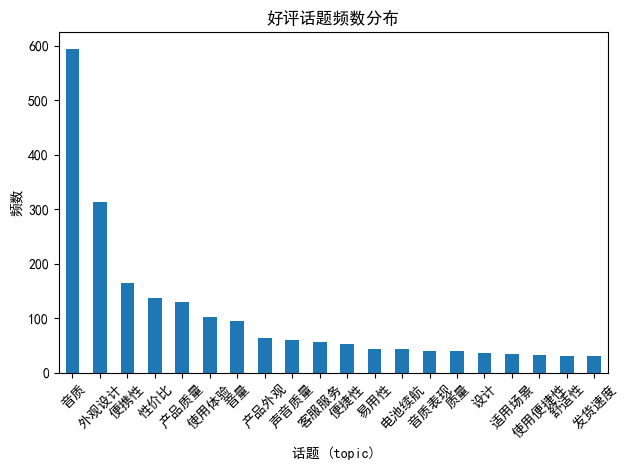

In [89]:
top_n = 20  # 只显示前20个
good_reviews = review_result_df_topic_exploded[review_result_df_topic_exploded['polarity'] == '好评']
topic_counts = good_reviews['topic'].value_counts()
topic_counts.head(top_n).plot(kind='bar')
plt.xlabel('话题 (topic)')
plt.ylabel('频数')
plt.title('好评话题频数分布')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

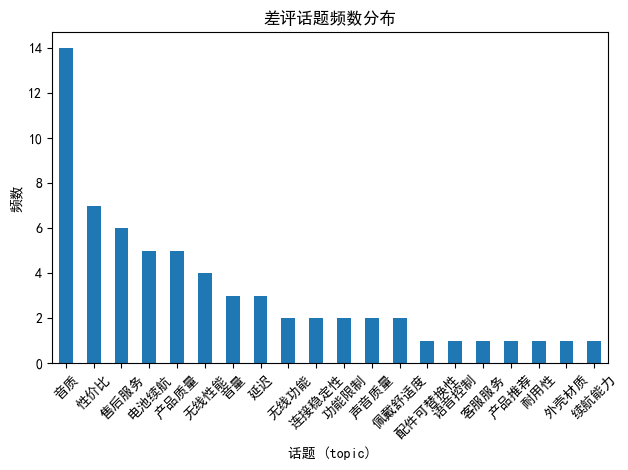

In [90]:
# 差评
bad_reviews = review_result_df_topic_exploded[review_result_df_topic_exploded['polarity'] == '差评']
topic_counts = bad_reviews['topic'].value_counts()
topic_counts.head(top_n).plot(kind='bar')
plt.xlabel('话题 (topic)')
plt.ylabel('频数')
plt.title('差评话题频数分布')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()